# Building a dataset of Ancient Roman coins by ruler, using webscraping
wildwinds.com contains an html-based list of Ancient Roman coins from the era of the Roman Empire, contained on separate pages for each emperor/honoree, with inconsistently formatted descriptions and data

### Import webscraping tools: requests, BeautifulSoup, and pandas

In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt

### Grab list of links for the landing pages of the various emperors/rulers/honorees from https://www.wildwinds.com/coins/ric/i.html

In [3]:
with requests.get('https://www.wildwinds.com/coins/ric/i.html') as raw:
    soup = BeautifulSoup(raw.content, 'lxml')

### Parse html data for a clean list of ruler names

In [4]:
options = soup.find_all('option')
emperors_raw = [i.contents for i in options if i.attrs['value'] != ''][:-6]
emperors = []
for line in emperors_raw:
    for text in line:
        emperors.append(text.strip())
print(f'First five: {emperors[:5]} \nLast five: {emperors[-5:]} \n{len(emperors)} emperors total')

First five: ['Aelia Ariadne', 'Aelia Flacilla', 'Aelia Verina', 'Aelius', 'Aemilian'] 
Last five: ['Vitellius', 'Volusian', 'Zeno', 'Zenobia', 'Zenonis'] 
231 emperors total


### Generate list of usable link roots for each Emperor's coin page

In [5]:
linkroots = ['https://www.wildwinds.com/coins/ric/' + i.attrs['value'][:-6] for i in options if i.attrs['value'] != ''][:-6]
print(f'First five: {linkroots[:5]} \nLast five: {linkroots[-5:]} \n{len(linkroots)} linkroots total')

First five: ['https://www.wildwinds.com/coins/ric/aelia_ariadne/', 'https://www.wildwinds.com/coins/ric/aelia_flaccilla/', 'https://www.wildwinds.com/coins/ric/aelia_verina/', 'https://www.wildwinds.com/coins/ric/aelius/', 'https://www.wildwinds.com/coins/ric/aemilian/'] 
Last five: ['https://www.wildwinds.com/coins/ric/vitellius/', 'https://www.wildwinds.com/coins/ric/volusian/', 'https://www.wildwinds.com/coins/ric/zeno/', 'https://www.wildwinds.com/coins/ric/zenobia/', 'https://www.wildwinds.com/coins/ric/zenonis/'] 
231 linkroots total


### Create a semi-random list of test pages for building an adaptable parser

In [6]:
testpages = [2, 4, 8, 12, 21, 42, 81, 118, 142, 196]
test_roots = [linkroots[i] for i in testpages]
for i in test_roots:
    print(i)

https://www.wildwinds.com/coins/ric/aelia_verina/
https://www.wildwinds.com/coins/ric/aemilian/
https://www.wildwinds.com/coins/ric/agrippina_II/
https://www.wildwinds.com/coins/ric/annius_verus/
https://www.wildwinds.com/coins/ric/augustus/
https://www.wildwinds.com/coins/ric/commodus/
https://www.wildwinds.com/coins/ric/galba/
https://www.wildwinds.com/coins/ric/laelianus/
https://www.wildwinds.com/coins/ric/martinian/
https://www.wildwinds.com/coins/ric/tacitus/


## pull html from test pages

In [7]:
test_pages_raw = [requests.get(linkroots[i] + 'i.html') for i in testpages]

## explore test page html

In [8]:
test_soups = [BeautifulSoup(test_pages_raw[i].content, 'lxml') for i in range(len(test_pages_raw))]

In [9]:
print(f'Test soup preview: \n\n{str(test_soups[4])[:1500]}')

Test soup preview: 

<html>
<head>
<title>Augustus, Roman Imperial Coins of, at WildWinds.com
</title>
<meta content="width=device-width, initial-scale=1" name="viewport"/>
<base target="_parent"/>
</head>
<body bgcolor="#D7D5D5">
<object data="https://www.wildwinds.com/coins/topscript.html" height="160" width="100%"></object><br/>
<center>
<p></p><h2>Browsing Roman Imperial Coins of Augustus</h2>
<p><img src="toppic.jpg"/>
<br/><font size="2">Octavian: Senator, Consul and Triumvir from 43 BC; de-facto sole ruler from 27 BC; proclaimed Augustus, emperor 12 BC - 14 AD.</font>
</p><h3><a href="t.html">Browse the Augustus page with thumbnail images.</a></h3>
<table border="1" cellpadding="0" cellspacing="1">
<tr><td>Note </td><td colspan="3">This page has later Roman Imperial issues from after Octavian was proclaimed Augustus in 27 BC. Earlier Imperatorial issues are listed on the <a href="../../imp/octavian/i.html">Octavian page</a>, though most Provincial issues are listed here regardle

### Create function to pull soup title

In [10]:
def pull_title(soup):
    raw_title = soup.find('title').contents[0]
    sep = raw_title.find(',')
    return str(raw_title[:sep])

In [11]:
def pull_title_test(soups=test_soups): 
    titles = pd.Series([pull_title(i) for i in soups])
    print(f'Out of {len(soups)} soups, {titles.isna().sum()} have missing titles.')

pull_title_test()
print('')
for soup in test_soups:
    print(pull_title(soup), sep=' ')

Out of 10 soups, 0 have missing titles.

Aelia Verina
Aemilian
Agrippina II
Annius Verus
Augustus
Commodus
Galba
Laelianus
Martinian
Tacitus


### Create a similar function to pull subtitles

In [12]:
def pull_subtitle(soup):
    try:
        subtitle = soup.find_all('h3')[0].contents[-1]
        if 'Click' in str(subtitle) or 'Browse' in str(subtitle):
            try:
                subtitle = soup.find('font').contents[0]
            except:
                return None
    except IndexError:
        try:
            subtitle = soup.find_all('p')[1].contents[-1]
            if 'Click' in str(subtitle) or 'Browse' in str(subtitle):
                raise IndexError
            elif len(subtitle) < 4:
                try:
                    subtitle = soup.find_all('br')[0].contents[0]
                except:
                    subtitle = None
        except IndexError:
            subtitle = None
    if '(' in str(subtitle) or '<' in str(subtitle):
        return None
    return str(subtitle).strip()

In [13]:
def pull_subtitle_test(soups=test_soups):
    subtitles = pd.Series([pull_subtitle(s) for s in soups])
    print(f'Out of {len(soups)} soups, {subtitles.isna().sum()} have missing subtitles.')

pull_subtitle_test()
print('')
for soup in test_soups:
    print(pull_subtitle(soup))
    

Out of 10 soups, 2 have missing subtitles.

Wife of Leo I. Died 484 AD.
Aemilian, 253 AD.
None
Son of Marcus Aurelius. Died 161 AD.
Octavian: Senator, Consul and Triumvir from 43 BC; de-facto sole ruler from 27 BC; proclaimed Augustus, emperor 12 BC - 14 AD.
Commodus, Caesar 172-179, Augustus 179-192 AD.
Galba, AD 68-69.
Ulpius Cornelius Laelianus, usurper against Postumus, 269 AD.
None
Tacitus, 275-276 AD.


### Create pull_coins to create a list of html chunks for each coin

In [14]:
def pull_coins(soup):
    coins = [coin.contents for coin in soup.find_all('tr') if len(coin) >2 and 'bgcolor' in str(coin)]
    return coins

In [15]:
pull_coins(test_soups[7])[:3]

[[<td bgcolor="#FFD700">RIC 1</td>,
  <td>Laelianus AV Aureus. Mainz or Trier mint, AD 268. IMP C LAELIANVS P F AVG, laureate &amp; cuirassed bust right / TEMPORVM FELICITAS, female figure reclining left, holding branch in right hand and resting left arm on hare. Cohen 2; Sear 11109.</td>,
  <td><a href="RIC_0001.txt">Text</a></td>,
  <td><a href="RIC_0001.jpg">Image</a></td>],
 [<td bgcolor="red">RIC 1 Becker<br/>Hill 234</td>,
  <td>Laelianvs. Becker Counterfeit struck, gold-plated aureus (6.12 gm). 19th century. IMP C LAELIANVS P F AVG, laureate and cuirassed bust right / TEMPORVM FELICITAS, female figure reclining left, holding branch in right hand and resting left arm on hare. Hill 234; Steinbüchel 97. Becker counterfeit of RIC 1; Elmer 623; Cohen 2 etc.</td>,
  <td><a href="RIC_0001-fake.txt">Text</a></td>,
  <td><a href="RIC_0001-fake.jpg">Image</a></td>],
 [<td bgcolor="#B87333">RIC 7</td>,
  <td>Laelianus, AE antoninianus. Cologne mint, AD 269. 22 mm, 3 g. IMP C LAELIANVS PF A

### Create coin_metal() to identify the coinage metal

In [16]:
def coin_metal(coin):
    metals = {'#B8':'Copper','#b8':'Copper', '#FF':'Gold', '#C0':'Silver', '#B7':'Brass', '#b7':'Brass', 'red':'FAKE'}
    try:
        bg_color_index = int(str(coin).find('bgcolor=')) + 9
        bg_color = str(coin)[bg_color_index:bg_color_index + 3]
        metal = metals[bg_color]
    except:
        return None
    return metal

### Create functions to pull coin era (i.e. 'AD' or 'BC') and <i>a</i> year (not <i>every</i> year) in the coin description 
(if there is a range of years i.e. 117-124 AD, function pulls the year closest to era i.e. '117-124 AD' returns '124', while 'AD 117-124' returns '117')

In [17]:
def coin_era(coin):
    coin = str(coin)
    if 'AD' in coin:
        return 'AD'
    elif 'BC' in coin:
        return 'BC'
    else:
        return None

def coin_year(coin):
    era = coin_era(coin)
    coin = str(coin)
    year = 0
    try:
        index = coin.find(coin_era(coin))
    except TypeError:
        return None
    if coin[index - 2].isnumeric():
        if coin[index - 3].isnumeric():
            if coin[index - 4].isnumeric():
                year += int(coin[index-4:index-1])
            else:
                year += int(coin[index-3:index-1])
        else:
            year += int(coin[index-2])
    elif coin[index + 3].isnumeric():
        if coin[index + 4].isnumeric():
            if coin[index + 5].isnumeric():
                year += int(coin[index+3:index+6])
            else:
                year += int(coin[index+3:index+4])
        else:
            year += int(coin[index+3])
    if era == 'AD':
        return year
    elif era == 'BC':
        return -year
    elif era == None:
        return None

### Create functions to pull .jpg and .txt links from coins

In [18]:
def coin_jpg(coin):
    for item in coin:
        item = str(item)
        if '.jpg' in item:
            start, end = item.find('href=')+6, item.find('.jpg')+4
            return item[start:end]

In [19]:
def coin_txt(coin):
    for item in coin:
        item = str(item)
        if '.txt' in item:
            start, end = item.find('href=')+6, item.find('.txt')+4
            return item[start:end]

### use code from above functions to create a crude function to pull coin_id from links

In [20]:
def coin_id(coin):
    coin = str(coin)
    if '.jpg' in coin:
        start, end = coin.rfind('href=')+6, coin.rfind('.jpg')
        return coin[start:end]
    elif '.txt' in coin:
        start, end = coin.rfind('href=')+6, coin.rfind('.txt')
        return coin[start:end]
    else:
        return None

### Create function for coin mass in grams

In [21]:
def coin_mass(coin):
    coin = str(coin)
    # might be able to clean this up by creating a list of possible gram abbreviations and looping through it
    if 'g.' in coin:
        start = coin.find('g.')
        if coin[start-1].isnumeric() or coin[start-2].isnumeric():
            grams = 'g.'
    elif 'g,' in coin:
        start = coin.find('g,')
        if coin[start-1].isnumeric() or coin[start-2].isnumeric():
            grams = 'g,'
    elif 'gm.' in coin:
        grams = 'gm.'
    elif 'gr.' in coin:
        grams = 'gr.'
    elif 'grs,' in coin:
        grams = 'grs,'
    elif 'grs.' in coin:
        grams = 'grs.'
    else:
        return None
    try:
        start = coin.find(grams)
        if coin[start-1].isnumeric():
            if coin[start-2] == '.':
                if coin[start-4].isnumeric():
                    return float(coin[start-4:start])
                else:
                    return float(coin[start-3:start])
        elif coin[start-3] == '.':
            if coin[start-5].isnumeric():
                return float(coin[start-5:start-1])
            else:
                return float(coin[start-4:start-1])
        else:
            if coin[start-6].isnumeric():
                return float(coin[start-6:start-1])
            else:
                return float(coin[start-5:start-1])
    except:
        return None

### Create function for coin size in mm

In [22]:
def coin_diameter(coin):
    coin = str(coin)
    if 'mm' in coin:
        start = coin.find('mm')
        # if there's no space between value and 'mm'
        if coin[start-1].isnumeric():
            if coin[start-2].isnumeric():
                # if value contains a decimal
                if coin[start-3] == '.': 
                    if coin[start-5:start-3].isnumeric():
                        return float(coin[start-5:start])
                    else:
                        return None
                else:
                    return float(coin[start-2:start])
            # if value contains a decimal
            elif coin[start-2] == '.':
                if coin[start-4:start-2].isnumeric():
                    return float(coin[start-4:start])
                else:
                    return None
        # if there is a space between value and 'mm'
        elif coin[start-1] == ' ' and coin[start-2].isnumeric():
            if coin[start-3].isnumeric():
                # if value contains a decimal
                if coin[start-4] == '.':
                    if coin[start-6:start-4].isnumeric():
                        return float(coin[start-6:start-1])
                    else:
                        return None
                else:
                    return float(coin[start-3:start-1])
            elif coin[start-3] == '.':
                if coin[start-5:start-3].isnumeric():
                    return float(coin[start-5:start-1])
                else:
                    return None


### Check for common inscriptions
...such as "AVG" (Augustus, title of the emperor), "IMP" (Imperator (victorious general), received upon accession), "CAES" (Caesar, inherited name of the Julian family (Julius Caesar), used by later emperors to designate heir), "GERM" (Germanicus, a title honoring military victories in Germany), "COS" or "CONSVL" (Consul, a title linked to highest office in Senate, usually held by emperor), "PO" (Pontifex Maximus, highest priest, the head of state religion), "PP" (Pater Patriae, father of the country), "PF" (Pius Felix, reverent or dutiful), "SC" (Senatus Consultus), "TPP" (Tribunica Potestate, tribune of the people, each renewal indicated by numerals), "CENS" (Censor, a public office overseeing taxes, morality, the census and membership in various orders), "BRIT" (Britannicus).

In [23]:
def coin_inscriptions(coin):
    coin = str(coin)
    inscriptions_list = ['AVG', 'IMP', 'CAES', 'GERM', 'COS', 'CONSVL', 'PP', 'PO', 'PF', \
                         'SC', 'CENS', 'TPP', 'TR', 'RESTITVT', 'BRIT', 'AVGVSTVS', 'CAESAR', 
                         'C', 'TRIB POT', 'PON MAX', 'PM']
    coin_inscriptions = []
    for i in inscriptions_list:
        if str(' ' + i + ' ') in coin:
            coin_inscriptions.append(i)
    if len(coin_inscriptions) > 0:
        return coin_inscriptions
    else:
        return None

def unique_inscriptions(inscriptions):
    u_inscriptions = []
    for i in inscriptions:
        try:
            for abb in i:
                if abb not in u_inscriptions:
                    u_inscriptions.append(abb)
        except TypeError:
            continue
    return u_inscriptions

### Create coin_tests() for a basic summary of function success

In [24]:
def coin_tests(soups=test_soups):
    test_coins = []
    for s in soups:
        for c in pull_coins(s):
            test_coins.append(c)
    print(f'Out of {len(test_coins)} coins in {len(soups)} soups, there are:')
    metals = pd.Series([coin_metal(coin) for coin in test_coins])
    print(f'  {metals.isna().sum()} missing metal values')
    print(f'    {metals.nunique()} unique metal values: {metals.unique()}')
    years = pd.Series([coin_year(coin) for coin in test_coins])
    print(f'  {years.isna().sum()} missing year values')
    print(f'    {years.nunique()} unique year values')
    print(f'      Mean: {years.mean()}, Median: {years.median()}, Min: {years.min()}, Max: {years.max()}')
    ids = pd.Series([coin_id(coin) for coin in test_coins])
    print(f'  {ids.isna().sum()} missing id values')
    print(f'    {ids.nunique()} unique id values')
    mass = pd.Series([coin_mass(coin) for coin in test_coins])
    print(f'  {mass.isna().sum()} missing mass values')
    print(f'    {mass.nunique()} unique mass values')
    print(f'      Mean: {mass.mean()}, Median: {mass.median()}, Min: {mass.min()}, Max: {mass.max()}')
    diameter = pd.Series([coin_diameter(coin) for coin in test_coins])
    print(f'  {diameter.isna().sum()} missing diameter values')
    print(f'    {diameter.nunique()} unique diameter values')
    print(f'      Mean: {diameter.mean()}, Median: {diameter.median()}, Min: {diameter.min()}, Max: {diameter.max()}')
    inscriptions = [coin_inscriptions(c) for c in test_coins]
    print(f'  {pd.Series(inscriptions).isna().sum()} missing inscriptions values')
    print(f'    {len(unique_inscriptions(inscriptions))} unique inscriptions')
    print(f'      {unique_inscriptions(inscriptions)}')

coin_tests()

Out of 2577 coins in 10 soups, there are:
  6 missing metal values
    5 unique metal values: ['Gold' 'Copper' 'Silver' 'Brass' None 'FAKE']
  1045 missing year values
    108 unique year values
      Mean: 107.7219321148825, Median: 177.0, Min: -225.0, Max: 570.0
  285 missing id values
    2147 unique id values
  1948 missing mass values
    520 unique mass values
      Mean: 11.64412559618442, Median: 8.6, Min: 0.655, Max: 71.7
  2417 missing diameter values
    46 unique diameter values
      Mean: 23.660187500000003, Median: 22.0, Min: 14.0, Max: 38.7
  1307 missing inscriptions values
    18 unique inscriptions
      ['AVG', 'IMP', 'TR', 'C', 'CAES', 'PF', 'PM', 'SC', 'PP', 'GERM', 'AVGVSTVS', 'CAESAR', 'COS', 'PO', 'PON MAX', 'TRIB POT', 'BRIT', 'RESTITVT']


## Combine individual coin parsing functions into one that returns a Dataframe
i.e. coin_df(soup)

In [25]:
def coin_df(soup):
    title = pull_title(soup)
    id, metal, mass, diameter, era, year, inscriptions, jpg, txt = [], [], [], [], [], [], [], [], []
    for coin in pull_coins(soup):
        id.append(coin_id(coin))
        metal.append(coin_metal(coin))
        mass.append(coin_mass(coin))
        diameter.append(coin_diameter(coin))
        era.append(coin_era(coin))
        year.append(coin_year(coin))
        inscriptions.append(coin_inscriptions(coin))
        jpg.append(coin_jpg(coin))
        txt.append(coin_txt(coin))
    return pd.DataFrame({'title':title, 'id':id, 'metal':metal, 'mass':mass, 'diameter':diameter, \
                         'era':era, 'year':year, 'inscriptions':inscriptions, 'jpg':jpg, 'txt':txt})

In [26]:
coin_df(test_soups[2]).head()

,title,id,metal,mass,diameter,era,year,inscriptions,jpg,txt
0,Agrippina II,Cohen_01,Brass,NaN,NaN,AD,5.0,[AVG],Cohen_01.jpg,Cohen_01.txt
1,Agrippina II,Cohen_01_countermarked,Brass,14.78,28.0,None,NaN,[AVG],Cohen_01_countermarked.jpg,Cohen_01_countermarked.txt
2,Agrippina II,RIC_0075,Silver,NaN,NaN,AD,54.0,"[CAES, GERM]",RIC_0075.jpg,RIC_0075.txt
3,Agrippina II,None,Brass,NaN,NaN,None,NaN,[AVG],None,None
4,Agrippina II,RIC_0103note,Brass,NaN,NaN,AD,54.0,[AVG],RIC_0103note.jpg,RIC_0103note.txt


## Create a function to combine multiple Dataframes

In [27]:
def combine_coin_dfs(soups):
    dfs = [coin_df(soup) for soup in soups]
    return pd.concat(dfs) 

In [28]:
len(combine_coin_dfs(test_soups))

2577

# Switch to working with full data

## Pull html from all source pages
(pulling from over 200 pages, which can take a few minutes)

In [29]:
pages_raw = [requests.get(linkroots[i] + 'i.html') for i in range(len(linkroots))]

In [30]:
all_soups = [BeautifulSoup(pages_raw[i].content, 'lxml') for i in range(len(pages_raw))]

#### Run tests

In [31]:
pull_title_test(all_soups)
pull_subtitle_test(all_soups)
coin_tests(all_soups)

Out of 231 soups, 0 have missing titles.
Out of 231 soups, 79 have missing subtitles.
Out of 40728 coins in 231 soups, there are:
  820 missing metal values
    5 unique metal values: ['Gold' 'Copper' 'Silver' 'Brass' None 'FAKE']
  16417 missing year values
    504 unique year values
      Mean: 204.09415490930033, Median: 217.0, Min: -853.0, Max: 956.0
  2385 missing id values
    33274 unique id values
  31689 missing mass values
    2471 unique mass values
      Mean: 10.016411439318532, Median: 7.52, Min: 0.32, Max: 516.0
  35370 missing diameter values
    479 unique diameter values
      Mean: 23.539531541620015, Median: 23.0, Min: 0.0, Max: 98.0
  23016 missing inscriptions values
    20 unique inscriptions
      ['AVG', 'COS', 'TR', 'CAESAR', 'TRIB POT', 'C', 'IMP', 'CAES', 'PF', 'PM', 'SC', 'PP', 'GERM', 'AVGVSTVS', 'PO', 'PON MAX', 'RESTITVT', 'BRIT', 'CONSVL', 'CENS']


## Combine it all into a single Dataframe

In [32]:
roman_coins_raw = combine_coin_dfs(all_soups)

In [33]:
roman_coins_raw.reset_index()
roman_coins_raw.index += 1

### Check data quality

In [34]:
roman_coins_raw.head(10)

,title,id,metal,mass,diameter,era,year,inscriptions,jpg,txt
1,Aelia Ariadne,RIC_0933a,Gold,1.46,14.0,AD,491,None,RIC_0933a.jpg,RIC_0933a.txt
2,Aelia Ariadne,RIC_933v,Gold,1.47,15.0,AD,491,None,RIC_933v.jpg,RIC_933v.txt
3,Aelia Ariadne,RIC_0933var2,Gold,4.47,NaN,AD,474,None,RIC_0933var2.jpg,RIC_0933var2.txt
4,Aelia Ariadne,RIC_0938,Gold,1.47,NaN,AD,474,None,RIC_0938.jpg,RIC_0938.txt
1,Aelia Flaccilla,_alexandria_RIC_017,Copper,None,NaN,None,NaN,None,_alexandria_RIC_017.jpg,_alexandria_RIC_017.txt
2,Aelia Flaccilla,_antioch_RIC_054,Copper,None,NaN,None,NaN,None,_antioch_RIC_054.jpg,_antioch_RIC_054.txt
3,Aelia Flaccilla,_antioch_RIC_061,Copper,None,NaN,None,NaN,None,_antioch_RIC_061.jpg,_antioch_RIC_061.txt
4,Aelia Flaccilla,_antioch_RIC_061_G,Copper,None,NaN,None,NaN,None,_antioch_RIC_061_G.jpg,_antioch_RIC_061_G.txt
5,Aelia Flaccilla,"_antioch_RIC_062,D",Copper,None,NaN,None,NaN,None,"_antioch_RIC_062,D.jpg","_antioch_RIC_062,D.txt"
6,Aelia Flaccilla,_antioch_RIC_062,Copper,None,22.0,None,NaN,None,_antioch_RIC_062.jpg,_antioch_RIC_062.txt


In [35]:
roman_coins_raw.describe()

,title,id,metal,mass,diameter,era,year,inscriptions,jpg,txt
count,40728,38343,39908,9039.0,5358.0,24311,24311.0,17712,38341,38342
unique,225,33274,5,2471.0,479.0,2,504.0,438,33174,33170
top,Caracalla,RIC_0013,Copper,2.9,18.0,AD,193.0,[PF],RIC_0013.jpg,RIC_0013.txt
freq,2411,23,28786,39.0,357.0,23774,994.0,2203,24,24


In [36]:
roman_coins = roman_coins_raw.drop_duplicates(subset=['id'])
roman_coins.head()


,title,id,metal,mass,diameter,era,year,inscriptions,jpg,txt
1,Aelia Ariadne,RIC_0933a,Gold,1.46,14.0,AD,491,None,RIC_0933a.jpg,RIC_0933a.txt
2,Aelia Ariadne,RIC_933v,Gold,1.47,15.0,AD,491,None,RIC_933v.jpg,RIC_933v.txt
3,Aelia Ariadne,RIC_0933var2,Gold,4.47,NaN,AD,474,None,RIC_0933var2.jpg,RIC_0933var2.txt
4,Aelia Ariadne,RIC_0938,Gold,1.47,NaN,AD,474,None,RIC_0938.jpg,RIC_0938.txt
1,Aelia Flaccilla,_alexandria_RIC_017,Copper,None,NaN,None,NaN,None,_alexandria_RIC_017.jpg,_alexandria_RIC_017.txt


In [37]:
roman_coins.describe()

,title,id,metal,mass,diameter,era,year,inscriptions,jpg,txt
count,33275,33274,32636,8178.0,4631.0,19641,19641.0,11663,33273,33273
unique,220,33274,5,2386.0,410.0,2,495.0,359,33156,33149
top,Caracalla,RIC_0933a,Copper,2.9,22.0,AD,193.0,[PF],RIC_0128.jpg,RIC_0128.txt
freq,2193,1,26757,36.0,305.0,19222,918.0,2067,3,3


In [38]:
roman_coins_years = roman_coins.dropna(subset=['metal', 'year'])
roman_coins_years = roman_coins_years[roman_coins_years['year']>float(-45.0)]
roman_coins_years = roman_coins_years[roman_coins_years['year']<float(500)]
roman_coins_years.sort_values(by='year').head()


,title,id,metal,mass,diameter,era,year,inscriptions,jpg,txt
3,Octavia,RPC_2574,Copper,0.93,None,BC,-43.0,None,RPC_2574.jpg,RPC_2574.txt
488,Augustus,RPC_0518,Copper,NaN,NaN,BC,-40.0,None,RPC_0518.jpg,RPC_0518.txt
797,Augustus,RPC_5421,Copper,NaN,18.0,BC,-38.0,None,RPC_5421.jpg,RPC_5421.txt
489,Augustus,RPC_0620,Brass,18.92,30.0,BC,-38.0,[CAESAR],RPC_0620.jpg,RPC_0620.txt
490,Augustus,RPC_0621,Brass,15.78,30.0,BC,-38.0,None,RPC_0621.jpg,RPC_0621.txt


In [39]:
roman_coins_years.describe()

,title,id,metal,mass,diameter,era,year,inscriptions,jpg,txt
count,19144,19143,19144,6276.0,2660.0,19144,19144.0,7322,19142,19143
unique,207,19143,5,2183.0,358.0,2,452.0,311,19102,19102
top,Caracalla,RIC_0933a,Copper,2.9,22.0,AD,193.0,[PF],RIC_0848.jpg,RIC_0848.txt
freq,1050,1,14961,26.0,185.0,18783,918.0,1231,2,2


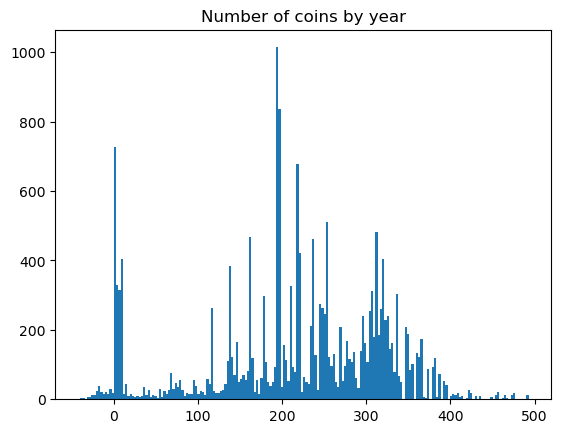

In [40]:
plt.hist(x=roman_coins_years['year'], bins=200)
plt.title('Number of coins by year')
plt.show()

In [65]:
roman_coins_mass = roman_coins.dropna(subset=['metal', 'mass'])
pd.to_numeric(roman_coins_mass['mass']).describe(percentiles=[.001, .01, .05, .25, .5, .75, .95, .99, .999])

count    8070.000000
mean       10.181004
std        10.519167
min         0.320000
0.1%        0.604830
1%          1.230000
5%          2.200000
25%         4.120000
50%         7.790000
75%        13.197500
95%        25.580000
99%        41.869300
99.9%      65.835820
max       516.000000
Name: mass, dtype: float64

In [66]:
roman_coins_mass = roman_coins_mass.query('mass>.6 and mass<66')
pd.to_numeric(roman_coins_mass['mass']).describe()

count    8053.000000
mean       10.038774
std         8.105817
min         0.670000
25%         4.130000
50%         7.790000
75%        13.160000
max        65.920000
Name: mass, dtype: float64

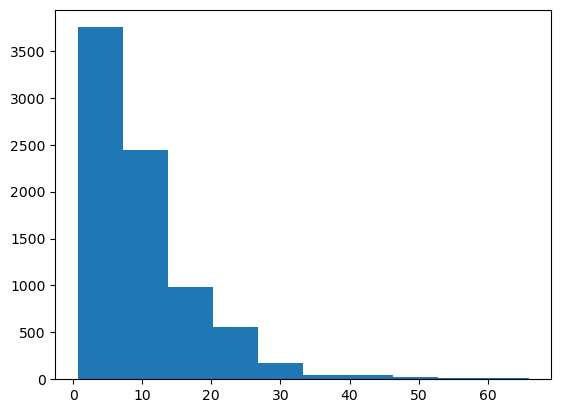

In [67]:

plt.hist(x=roman_coins_mass['mass'])
plt.show()

### run code chunk below to save new Dataframe as csv files

In [68]:
roman_coins_raw.to_csv('roman_coins_raw.csv')
roman_coins.to_csv('roman_coins.csv')
roman_coins_years.to_csv('roman_coins_years.csv')
roman_coins_mass.to_csv('roman_coins_mass.csv')

## Create Dataframe for just titles and subtitles 
(since subtitles are often too long to fit comfortably in a Dataframe - useful for later joins if subtitles are desired)

In [84]:
# titles_and_subtitles = 
    